# Install Packages

## Clip model

In [ ]:
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-b8slmib_
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-b8slmib_
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done


In [ ]:
import os
import clip
import torch
from torchvision.datasets import CIFAR100
from PIL import Image

# Load the model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load('ViT-L/14@336px', device)

In [ ]:
import matplotlib.pyplot as plt


## Grounding Dino

In [ ]:
import os
HOME = os.getcwd()
print(HOME)

/content


In [ ]:
%cd {HOME}
!git clone https://github.com/IDEA-Research/GroundingDINO.git
%cd {HOME}/GroundingDINO
!pip install -q -e .
# !pip install -q roboflow

/content
fatal: destination path 'GroundingDINO' already exists and is not an empty directory.
/content/GroundingDINO
  Preparing metadata (setup.py) ... done


In [ ]:
!mkdir weights
!cd weights
!wget -q https://github.com/IDEA-Research/GroundingDINO/releases/download/v0.1.0-alpha/groundingdino_swint_ogc.pth
!cd ..

mkdir: cannot create directory ‘weights’: File exists


In [ ]:
import os

CONFIG_PATH = os.path.join(HOME, "GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py")
print(CONFIG_PATH, "; exist:", os.path.isfile(CONFIG_PATH))

/content/GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py ; exist: True


In [ ]:
%cd {HOME}
!mkdir {HOME}/weights
%cd {HOME}/weights

!wget -q https://github.com/IDEA-Research/GroundingDINO/releases/download/v0.1.0-alpha/groundingdino_swint_ogc.pth

/content
mkdir: cannot create directory ‘/content/weights’: File exists
/content/weights


In [ ]:
import os

WEIGHTS_NAME = "groundingdino_swint_ogc.pth"
WEIGHTS_PATH = os.path.join(HOME, "weights", WEIGHTS_NAME)
print(WEIGHTS_PATH, "; exist:", os.path.isfile(WEIGHTS_PATH))

/content/weights/groundingdino_swint_ogc.pth ; exist: True


In [ ]:
%cd {HOME}/GroundingDINO

from groundingdino.util.inference import load_model, load_image, predict, annotate

model = load_model(CONFIG_PATH, WEIGHTS_PATH)

/content/GroundingDINO


final text_encoder_type: bert-base-uncased


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.


## grounding dino

In [ ]:
import matplotlib.pyplot as plt
import supervision as sv
def process_image_with_annotations(image_path, text_prompt='human head', box_threshold=0.1, text_threshold=0.1):

    image_source, image = load_image(image_path)

    boxes, logits, phrases = predict(
        model=model,
        image=image,
        caption=text_prompt,
        box_threshold=0.35,
        text_threshold=0.25
    )

    annotated_frame = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)

    num_boxes = len(boxes)

    %matplotlib inline
    plt.figure(figsize=(16, 16))
    sv.plot_image(annotated_frame, (16, 16))
    plt.show()

    return num_boxes


## clip model

In [ ]:
import torch
import clip
from PIL import Image
import matplotlib.pyplot as plt

def classify_image(image_path):
    labels = ['pub', 'restaurant', 'grocery store', 'supermarket', 'party']

    device = "cuda" if torch.cuda.is_available() else "cpu"
    model, preprocess = clip.load("ViT-B/32", device=device)

    image = Image.open(image_path)
    image_input = preprocess(image).unsqueeze(0).to(device)

    text_inputs = torch.cat([clip.tokenize(f"a photo of {label}") for label in labels]).to(device)

    with torch.no_grad():
        image_features = model.encode_image(image_input)
        text_features = model.encode_text(text_inputs)

    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)

    similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
    values, indices = similarity[0].topk(len(labels))

    print("\nTop predictions:\n")
    for value, index in zip(values, indices):
        print(f"{labels[index]:>16s}: {100 * value.item():.2f}%")


In [ ]:
def classify_emo(image_path):

    labels = ['Happy', 'Angry', 'Enjoyable', 'Relaxed', 'Neutral']

    # Load the model
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model, preprocess = clip.load("ViT-B/32", device=device)

    # Open and preprocess the image
    image = Image.open(image_path)
    image_input = preprocess(image).unsqueeze(0).to(device)

    # Prepare the text inputs
    text_inputs = torch.cat([clip.tokenize(f"a photo of {label}") for label in labels]).to(device)

    # Encode the image and text inputs
    with torch.no_grad():
        image_features = model.encode_image(image_input)
        text_features = model.encode_text(text_inputs)

    # Normalize the features
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)

    # Calculate similarity and get top predictions
    similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
    values, indices = similarity[0].topk(len(labels))  # Adjust as needed

    # Store scores
    scores = []
    print("\nTop predictions:\n")
    for value, index in zip(values, indices):
        print(f"{labels[index]:>16s}: {100 * value.item():.2f}%")

In [ ]:
def process_and_classify(image_path):
    num_boxes = process_image_with_annotations(image_path)
    print(f"Number of bounding boxes: {num_boxes}")
    classify_image(image_path)

    if num_boxes >= 1:
        scores = classify_emo(image_path)

SupervisionWarnings: annotate is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


<Figure size 1600x1600 with 0 Axes>

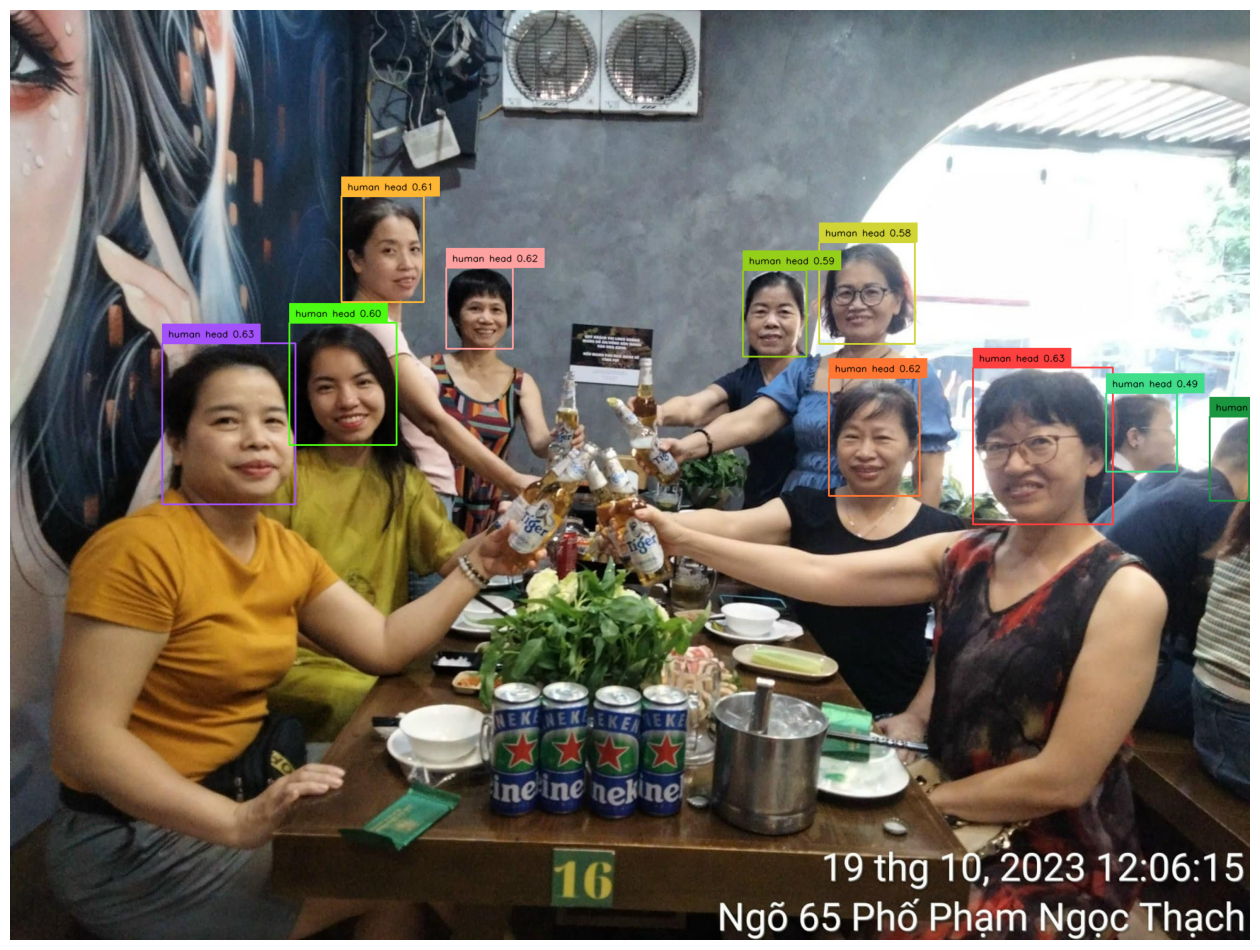

Number of bounding boxes: 10

Top predictions:

           party: 57.03%
      restaurant: 27.37%
             pub: 13.76%
   grocery store: 1.01%
     supermarket: 0.83%

Top predictions:

           Happy: 51.95%
       Enjoyable: 29.59%
         Neutral: 8.22%
         Relaxed: 5.83%
           Angry: 4.40%


In [ ]:
image_path = "/content/hinh.jpg"
process_and_classify(image_path)